In [1]:
using RigidBodyDynamics
using ForwardDiff
using Plots

In [2]:
struct Model
    f::Function # continuous dynamics (ie, differential equation)
    n::Int # number of states
    m::Int # number of controls

    function Model(f::Function, n::Int64, m::Int64)
        # construct a model from an explicit differential equation
        new(f,n,m)
    end

    function Model(mech::Mechanism)
        # fully actuated
        m = length(joints(mech))-1  # subtract off joint to world
        Model(mech,ones(m,1))
    end

    function Model(mech::Mechanism,torques::Array)

        # construct a model using robot dynamics equation assembed from URDF file
        n = num_positions(mech) + num_velocities(mech) + num_additional_states(mech)
        num_joints = length(joints(mech))-1  # subtract off joint to world
        m = num_joints # Default to number of joints

        function fc(x,u)
            state = MechanismState{eltype(x)}(mech)

            # set the state variables:
            q = x[1:num_joints]
            qd = x[(1:num_joints)+num_joints]
            set_configuration!(state, q)
            set_velocity!(state, qd)

            [qd; Array(mass_matrix(state))\(torques.*u) - Array(mass_matrix(state))\Array(dynamics_bias(state))]
        end
        new(fc, n, convert(Int,sum(torques)))
    end
end

function Model(urdf::String)
    # construct modeling using string to urdf file
    mech = parse_urdf(Float64,urdf)
    Model(mech)
end

function Model(urdf::String,torques::Array{Float64,1})
    # underactuated system (potentially)
    # construct modeling using string to urdf file
    mech = parse_urdf(Float64,urdf)
    Model(mech,torques)
end

Model

In [3]:
# cost function
struct Objective
    Q::Array{Float64,2}
    R::Array{Float64,2}
    Qf::Array{Float64,2}
    tf::Float64
    x0::Array{Float64,1}
    xf::Array{Float64,1}
end

In [4]:
struct Solver
    model::Model
    obj::Objective
    dt::Float64
    fd::Function  # discrete dynamics
    F::Function
    N::Int

    function Solver(model::Model, obj::Objective, discretizer::Function=rk4; dt=0.01)
        fd = discretizer(model.f, dt)     # Discrete dynamics
        f_aug = f_augmented(model)  # Augmented continuous dynamics
        fd_aug = discretizer(f_aug)  # Augmented discrete dynamics
        F(S) = ForwardDiff.jacobian(fd_aug, S)

        function Jacobians(x::Array,u::Array)
            F_aug = F([x;u;dt])
            fx = F_aug[1:model.n,1:model.n]
            fu = F_aug[1:model.n,model.n+1:model.n+model.m]
            return fx, fu
        end

        N = Int(floor(obj.tf/dt));
        new(model, obj, dt, fd, Jacobians, N)
    end
end

# Midpoint Integrator
function f_midpoint(f::Function, dt::Float64)
    dynamics_midpoint(x,u)  = x + f(x + f(x,u)*dt/2, u)*dt
end

function f_midpoint(f::Function)
    dynamics_midpoint(S::Array)  = S + f(S + f(S)*S[end]/2)*S[end]
end

# RK4 Integrator
function rk4(f::Function,dt::Float64)
    # Runge-Kutta 4
    k1(x,u) = dt*f(x,u)
    k2(x,u) = dt*f(x + k1(x,u)/2.,u)
    k3(x,u) = dt*f(x + k2(x,u)/2.,u)
    k4(x,u) = dt*f(x + k3(x,u), u)
    fd(x,u) = x + (k1(x,u) + 2.*k2(x,u) + 2.*k3(x,u) + k4(x,u))/6.
end

function rk4(f_aug::Function)
    # Runge-Kutta 4
    fd(S::Array) = begin
        k1(S) = S[end]*f_aug(S)
        k2(S) = S[end]*f_aug(S + k1(S)/2.)
        k3(S) = S[end]*f_aug(S + k2(S)/2.)
        k4(S) = S[end]*f_aug(S + k3(S))
        S + (k1(S) + 2.*k2(S) + 2.*k3(S) + k4(S))/6.
    end
end

# Assembled augmented function
function f_augmented(model::Model)
    f_aug = f_augmented(model.f, model.n, model.m)
    f(S::Array) = [f_aug(S); zeros(model.m+1,1)]
end

function f_augmented(f::Function, n::Int, m::Int)
    f_aug(S::Array) = f(S[1:n], S[n+(1:m)])
end

f_augmented (generic function with 2 methods)

In [5]:
#iLQR
function rollout!(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    X[:,1] = solver.obj.x0
    for k = 1:solver.N-1
        X[:,k+1] = solver.fd(X[:,k],U[:,k])
    end
end

function rollout!(solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, alpha::Float64, X_::Array{Float64,2}, U_::Array{Float64,2})
    N = solver.N
    X_[:,1] = solver.obj.x0;
    for k = 2:N
        a = alpha*(d[:,k-1]);
        delta = (X_[:,k-1] - X[:,k-1])

        U_[:, k-1] = U[:, k-1] - K[:,:,k-1]*delta - a;
        X_[:,k] = solver.fd(X_[:,k-1], U_[:,k-1]);
        if ~all(isfinite, X_[:,k]) || ~all(isfinite, U_[:,k-1])
            return false
        end
    end
    return true
end

# function rollout!(solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, alpha::Float64)
#     N = solver.N
#     X_ = zeros(solver.model.n, N);
#     U_ = zeros(solver.model.m, N)
#     rollout!(solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2},
#         alpha::Float64, X_::Array{Float64,2}, U_::Array{Float64,2})
#     return X_, U_
# end

function cost(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    N = solver.N
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf

    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

# overloaded cost function to accomodate Augmented Lagrance method
function cost(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},C::Array{Float64,2},I_mu::Array{Float64,3},LAMBDA::Array{Float64,2})
    J = cost(solver,X,U)
    for k = 1:solver.N
        J += 0.5*(C[:,k]'*I_mu[:,:,k]*C[:,k] + LAMBDA[:,k]'*C[:,k])
    end
    if J < 0.0
        println("NEGATIVE COST PROBLEM!")
        println(LAMBDA)
        println(size(LAMBDA,1)*size(LAMBDA,2))
        println(sum(LAMBDA.*C.<0.))
        println(LAMBDA.*C.<0.)
        
    end
    return J
end

function backwardpass(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2},C::Array{Float64,2},Cx::Array{Float64,3},Cu::Array{Float64,3},I_mu::Array{Float64,3},LAMBDA::Array{Float64,2})
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf

    S = Qf
    s = Qf*(X[:,N] - xf)
    v1 = 0.
    v2 = 0.

    mu = 0.
    k = N-1
    while k >= 1
        lx = Q*(X[:,k] - xf)
        lu = R*(U[:,k])
        lxx = Q
        luu = R
        fx, fu = solver.F(X[:,k],U[:,k])
        Qx = lx + fx'*s 
        Qu = lu + fu'*s 
        Qxx = lxx + fx'*S*fx
        Quu = luu + fu'*(S + mu*eye(n))*fu
        Qux = fu'*(S + mu*eye(n))*fx

        # regularization
        if any(eigvals(Quu).<0.)
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end
        
        # Constraints
        Qx += Cx[:,:,k]'*I_mu[:,:,k]*C[:,k] + Cx[:,:,k]'*LAMBDA[:,k]
        Qu += Cu[:,:,k]'*I_mu[:,:,k]*C[:,k] + Cu[:,:,k]'*LAMBDA[:,k]
        Qxx += Cx[:,:,k]'*I_mu[:,:,k]*Cx[:,:,k]
        Quu += Cu[:,:,k]'*I_mu[:,:,k]*Cu[:,:,k]
        Qux += Cu[:,:,k]'*I_mu[:,:,k]*Cx[:,:,k]
        
        K[:,:,k] = Quu\Qux
        d[:,k] = Quu\Qu
        s = (Qx' - Qu'*K[:,:,k] + d[:,k]'*Quu*K[:,:,k] - d[:,k]'*Qux)'
        S = Qxx + K[:,:,k]'*Quu*K[:,:,k] - K[:,:,k]'*Qux - Qux'*K[:,:,k]

        # terms for line search
        v1 += float(d[:,k]'*Qu)[1]
        v2 += float(d[:,k]'*Quu*d[:,k])

        k = k - 1;
    end
    return K, d, v1, v2
end


function backwardpass(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2})
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf

    S = Qf
    s = Qf*(X[:,N] - xf)
    v1 = 0.
    v2 = 0.

    mu = 0.
    k = N-1
    while k >= 1
        lx = Q*(X[:,k] - xf)
        lu = R*(U[:,k])
        lxx = Q
        luu = R
        fx, fu = solver.F(X[:,k],U[:,k])
        Qx = lx + fx'*s
        Qu = lu + fu'*s
        Qxx = lxx + fx'*S*fx
        Quu = luu + fu'*(S + mu*eye(n))*fu
        Qux = fu'*(S + mu*eye(n))*fx

#         # regularization
#         if any(eigvals(Quu).<0.)
#             mu = mu + 1.0;
#             k = N-1;
#             println("regularized")
#         end

        K[:,:,k] = Quu\Qux
        d[:,k] = Quu\Qu
        s = (Qx' - Qu'*K[:,:,k] + d[:,k]'*Quu*K[:,:,k] - d[:,k]'*Qux)'
        S = Qxx + K[:,:,k]'*Quu*K[:,:,k] - K[:,:,k]'*Qux - Qux'*K[:,:,k]

        # terms for line search
        v1 += float(d[:,k]'*Qu)[1]
        v2 += float(d[:,k]'*Quu*d[:,k])

        k = k - 1;
    end
    return K, d, v1, v2
end

function forwardpass!(X_, U_, solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, v1::Float64, v2::Float64, C_function::Function,I_mu_function::Function,LAMBDA::Array{Float64,2},MU::Array{Float64,2}, c1::Float64=1e-4, c2::Float64=1.0)

    # Compute original cost
    J_prev = cost(solver, X, U, C_function(X,U), I_mu_function(X,U,LAMBDA,MU), LAMBDA)

    J = Inf
    alpha = 1.0
    iter = 0
    dV = Inf
    z = 0.

    while z < c1 || z > c2
        flag = rollout!(solver, X, U, K, d, alpha, X_, U_)

        # Check if rollout completed
        if ~flag
            # println("Bad X bar values")
            alpha /= 2.
            continue
        end

        # Calcuate cost
        
        J = cost(solver, X_, U_, C_function(X_,U_), I_mu_function(X_,U_,LAMBDA,MU), LAMBDA)
        dV = alpha*v1 + (alpha^2)*v2/2.
        z = (J_prev - J)/dV[1,1]
        if iter < 10
            alpha = alpha/2.
        else
            alpha = alpha/10.
        end
        iter = iter + 1
        
#         println("- Expected improvement: $(dV[1])")
#         println("- Actual improvement: $(J_prev-J)")
#         println("- (z = $z)\n")

        if iter > 25
            println("^^^max iterations (forward pass)^^^")
            rollout!(solver, X, U, K, d, 0.0, X_, U_) #probably unnecessary 
            break
        end
        iter += 1
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(J_prev-J)")
    println("- (z = $z)\n")

    return J

end

function solve(solver::Solver)
    U = zeros(solver.model.m, solver.N)
    solve(solver,U)
end

solve (generic function with 1 method)

In [52]:
function solve(solver::Solver,U::Array{Float64,2},iterations::Int64=100,eps::Float64=1e-2)
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    X = zeros(n,N)
    X_ = similar(X)
    U_ = similar(U)
    K = zeros(m,n,N-1)
    d = zeros(m,N-1)
    J = 0.

    ### Constraints
    p = 2*m + n
    LAMBDA = zeros(p,N)
    MU = ones(p,N)
    u_min = [-6.;-6.]
    u_max = [6.;6.]
    xf = solver.obj.xf
    
    
    function control_constraints(X,U)
        c = zeros(2*size(U,1),N)

        for i = 1:N-1
            c[:,i] = [u_max - U[:,i]; U[:,i] - u_min]
        end

        return c
    end

    function control_constraints_derivatives(X,U)
        c = zeros(2*size(U,1),size(U,1),N)

        for i = 1:N-1
            c[:,:,i] = [-eye(size(U,1)); eye(size(U,1))]
        end

        return c
    end

    function terminal_state_constraints(X,U)
        c = zeros(size(X,1),N)
        c[:,N] = X[:,end] - xf
        return c
    end

    function terminal_state_constraints_derivatives(X,U)
        c = zeros(size(X,1),size(X,1),N)
        c[:,:,N] = eye(size(X,1))
        return c
    end

    function C(X,U)
        return [control_constraints(X,U); terminal_state_constraints(X,U)]
    end

    function Cx(X,U)
        return [zeros(2*size(U,1),size(X,1),N); terminal_state_constraints_derivatives(X,U)]
    end

    function Cu(X,U)
        return [control_constraints_derivatives(X,U); zeros(size(X,1),size(U,1),N)]
    end

    function I_mu(X,U,LAMBDA,MU)
        I = zeros(size(U,1)*2 + size(X,1),size(U,1)*2 + size(X,1),N)
        m = 2*size(U,1) # number of inequality constraints
        c = C(X,U)
        for k = 1:N
            # inequality constraints (controls)
            for j = 1:m
                if c[j,k] < 0. || LAMBDA[j,k] < 0.
                    I[j,j,k] = MU[j,k]
                end
            end

            # equality constraints (terminal state constraint)
            for j = m+1:m+size(X,1)
                if k == N
                    I[j,j,k] = MU[j,k]
                end
            end

        end
        return I
    end  
    
    ### SOLVER
    
    # initial roll-out
    X[:,1] = solver.obj.x0
    rollout!(solver, X, U)
    
    for k = 1:10
        if k == 10
            eps = 1e-5
        end
        J_prev = cost(solver, X, U, C(X,U), I_mu(X,U,LAMBDA,MU), LAMBDA)
        println("Cost ($k): $J_prev\n")
        
        for i = 1:iterations
            println("--Iteration: $k-($i)--")
            K, d, v1, v2 = backwardpass(solver,X,U,K,d, C(X,U), Cx(X,U), Cu(X,U), I_mu(X,U,LAMBDA,MU), LAMBDA)
            J = forwardpass!(X_, U_, solver, X, U, K, d, v1, v2, C, I_mu, LAMBDA, MU)
            X = copy(X_)
            U = copy(U_)
            dJ = abs(J-J_prev)
            J_prev = copy(J)
            
            if dJ < eps
                println("   eps criteria met at iteration: $i\n")
                break
            end
        end
        
        # Outer Loop - update lambda, mu
        println("Constraint update")
        c = C(X,U)
        for jj = 1:N
            for ii = 1:p
                if ii <= 2*m
                    LAMBDA[ii,jj] += MU[ii,jj]*min(c[ii,jj],0) # inequality constraints, only update lambda if active
                elseif ii > 2*m
                    LAMBDA[ii,jj] += MU[ii,jj]*c[ii,jj] # equality constraints, update all
                end
                
                MU[ii,jj] += 10.0
            end
        end
    end  

    return X, U, C(X,U), LAMBDA, MU
    
end

solve (generic function with 4 methods)

In [53]:
# Double Pendulum
urdf = "doublependulum.urdf"
doublependulum = parse_urdf(Float64,urdf)
state = MechanismState(doublependulum)

model = Model(urdf)
n = 4 # number of states
m = 2 # number of controls

# initial and goal states
x0 = [0.;0.;0.;0.]
xf = [pi;0.;0.;0.]

# costs
Q = 0.0001*eye(n)
Qf = 250.0*eye(n)
R = 0.0001*eye(m)

# simulation
tf = 5.0
dt = 0.1

obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(model,obj,dt=dt) 

Solver(Model(fc, 4, 2), Objective([0.0001 0.0 0.0 0.0; 0.0 0.0001 0.0 0.0; 0.0 0.0 0.0001 0.0; 0.0 0.0 0.0 0.0001], [0.0001 0.0; 0.0 0.0001], [250.0 0.0 0.0 0.0; 0.0 250.0 0.0 0.0; 0.0 0.0 250.0 0.0; 0.0 0.0 0.0 250.0], 5.0, [0.0, 0.0, 0.0, 0.0], [3.14159, 0.0, 0.0, 0.0]), 0.1, fd, Jacobians, 50)

In [54]:
# run solver
U = 10.*rand(solver.model.m,solver.N-1)
X_pendulum, U_pendulum, Cs, Ls, Ms = @time solve(solver,U);

Cost (1): 1152.927839587588

--Iteration: 1-(1)--
New cost: 984.276613715624
- Expected improvement: 305.09613468075014
- Actual improvement: 168.65122587196413
- (z = 0.5527806048688203)

--Iteration: 1-(2)--
New cost: 872.5515295951724
- Expected improvement: 551.5882757375558
- Actual improvement: 111.72508412045158
- (z = 0.20255159334389128)

--Iteration: 1-(3)--
New cost: 766.7396227889044
- Expected improvement: 231.33102379293754
- Actual improvement: 105.81190680626798
- (z = 0.4574047400619267)

--Iteration: 1-(4)--
New cost: 452.73699531858875
- Expected improvement: 430.5135165887051
- Actual improvement: 314.00262747031564
- (z = 0.7293676397396387)

--Iteration: 1-(5)--
New cost: 121.56069473639663
- Expected improvement: 564.959368739525
- Actual improvement: 331.17630058219214
- (z = 0.5861948998581548)

--Iteration: 1-(6)--
New cost: 52.73927199341962
- Expected improvement: 151.55095653349753
- Actual improvement: 68.821422742977
- (z = 0.454114076988787)

--Iteration

[3.14133, -9.0339e-5, 0.000127477, 4.99173e-5]


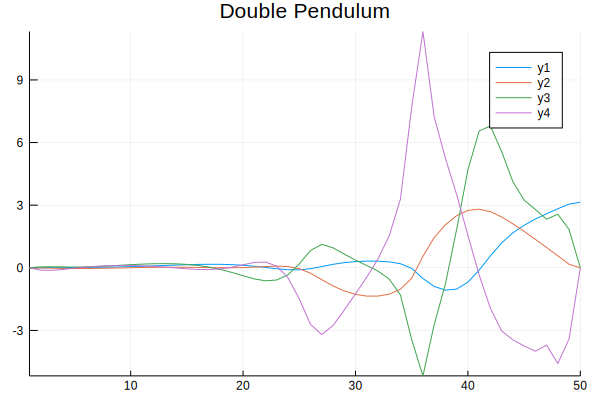

In [55]:
println(X_pendulum[:,end])
plot(X_pendulum',title="Double Pendulum")

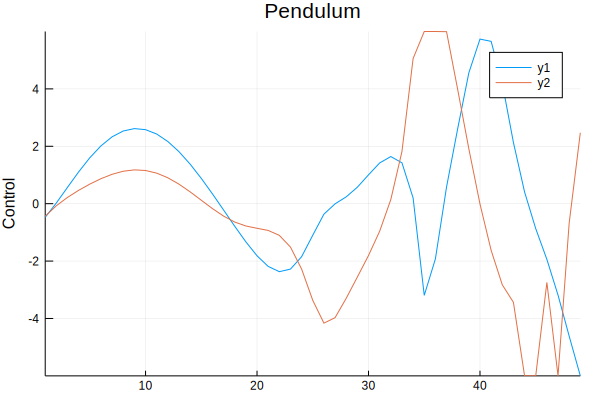

In [56]:
plot(U_pendulum',title="Pendulum",ylabel="Control")